In [29]:
from vampires_calibration.csv_tools import read_csv,read_csv_physical_model_all_bins,model_data
from vampires_calibration.fitting import model
from vampires_calibration.utils import *
from vampires_calibration.constants import wavelength_bins
from pyMuellerMat.physical_models.charis_physical_models import *
import pandas as pd
import matplotlib.pyplot as plt

In [43]:
# calculate s rel 

interleaved_values_internal, interleaved_stds_internal, config_list_internal = read_csv_physical_model_all_bins('/Users/thomasmcintosh/Desktop/CHARIS-REU/vampires_calibration/vampires_calibration/CHARIS/datacsvs/csvs_pickoff')
dds_internal = np.array(process_dataset(interleaved_values_internal)[::2])
dds_internal.shape

(704,)

In [39]:
# get naive fit retardances (where offsets were fit to)

df = model_data('../system_dictionaries/scipy_minimize_just_rets',offsets=False )
hwp_phi_list = df['hwp_phi'].values

df_eps = model_data('../system_dictionaries/diattenuations_cal_polarizer' )
df_wol = model_data('/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/naive_fitting/imr_naive_wollaston_trans')
imr_phi_list = df_wol['image_rotator_phi'].values
# repeat each retardance for each measurement in csv
hwp_phi_list = np.array([i for i in hwp_phi_list for _ in range(64)])
imr_phi_list = np.array([i for i in imr_phi_list for _ in range(64)])
#lp_epsilon_list = np.array([i for i in df_wol['lp_epsilon'].values for _ in range(64)])
wol_eta_list = np.array([i for i in df_wol['wollaston_eta'].values for _ in range(64)])
bin_list = np.array([i for i in wavelength_bins for _ in range(64)])
df_wol

,wavelength_bin,image_rotator_phi,wollaston_eta
0,1159.5614,4.313231,1.000000
1,1199.6971,4.044694,0.991889
2,1241.2219,3.817942,0.996194
3,1284.1840,3.538481,0.986676
4,1328.6331,3.153569,0.979581
5,1374.6208,2.745973,0.988795
6,1422.2002,2.464157,0.990110
7,1471.4264,2.187645,0.991901
8,1522.3565,1.938894,0.991252
9,1575.0495,1.728392,0.993858


In [40]:
modeled_internal = np.array([])
for dd in range(len(config_list_internal)):

    # get model ready
    hwp_phi = hwp_phi_list[dd]
    imr_phi = imr_phi_list[dd]
    offset_imr = -0.13959
    offset_hwp = -1.59338
    offset_cal = -0.11835
    lp_eps = 1
    wavelength_bin = bin_list[dd]
    hwp_phi = HWP_retardance(wavelength_bin, 1.63398,1.27711)[0]
    #imr_phi = IMR_retardance(wavelength_bin ,259.11814)[0]
    wol_eta = wol_eta_list[dd]

    # define system dictionary
    system_dict = {
            "components" : {
                "wollaston" : {
                "type" : "wollaston_prism_function",
                "properties" : {"beam": 'o','eta':wol_eta}, 
                "tag": "internal",
                },
                "image_rotator" : {
                    "type" : "general_retarder_function",
                    "properties" : {"phi": imr_phi, "theta": 0, "delta_theta": offset_imr},
                    "tag": "internal",
                },
                "hwp" : {
                    "type" : "general_retarder_function",
                    "properties" : {"phi": hwp_phi, "theta": 0, "delta_theta": offset_hwp},
                    "tag": "internal",
                },
                "lp_rot": {
                    "type": "rotator_function",
                    "properties": {"theta": offset_cal},
                    "tag": "internal",
                },
                "lp" : {  # calibration polarizer for internal calibration source
                    "type": "diattenuator_retarder_function",
                    "properties": {"epsilon": lp_eps},
                    "tag": "internal",
                }},
        }
    
    # define p0 dict (it doesnt do anything its just necessary for model function to work)

    p0_dict = {
    "lp" : 
        {"epsilon":lp_eps}
}

    # generate system mueller matrix    
    system_mm = generate_system_mueller_matrix(system_dict)
    p, pkeys = parse_configuration(p0_dict)
    
    # generate model
    configlist = [config_list_internal[dd]]
    modeled_dd = model(p, pkeys, system_mm, configlist)
    modeled_internal = np.concatenate((modeled_internal, modeled_dd))

modeled_internal = process_model(modeled_internal)[::2]

print(modeled_internal)

Parameter 'wavelength' not found in component 'hwp'. Skipping...
Parameter 'wavelength' not found in component 'image_rotator'. Skipping...
Parameter 'wavelength' not found in component 'hwp'. Skipping...
Parameter 'wavelength' not found in component 'image_rotator'. Skipping...
Parameter 'wavelength' not found in component 'hwp'. Skipping...
Parameter 'wavelength' not found in component 'image_rotator'. Skipping...
Parameter 'wavelength' not found in component 'hwp'. Skipping...
Parameter 'wavelength' not found in component 'image_rotator'. Skipping...
Parameter 'wavelength' not found in component 'hwp'. Skipping...
Parameter 'wavelength' not found in component 'image_rotator'. Skipping...
Parameter 'wavelength' not found in component 'hwp'. Skipping...
Parameter 'wavelength' not found in component 'image_rotator'. Skipping...
Parameter 'wavelength' not found in component 'hwp'. Skipping...
Parameter 'wavelength' not found in component 'image_rotator'. Skipping...
Parameter 'wavelengt

In [41]:
# calculate s res

# generate s
s_res_by_wavelength = []
for bin in range(22):
    # mask per bin
    bin_mask = []
    for dict in config_list_internal[::2]:
        if dict['hwp']['wavelength'] == wavelength_bins[bin]:
            bin_mask.append(True)
        else:
            bin_mask.append(False)

    # apply mask
    double_diffs_bin = dds_internal[bin_mask]
    modeled_double_differences_bin = modeled_internal[bin_mask]
    # calculate s_res as in appendix E of SPHERE cal paper
    residuals = (double_diffs_bin*100-modeled_double_differences_bin*100)
    s_res = np.sqrt(np.sum(residuals**2)/(len(dds_internal[bin_mask])))
    s_res_by_wavelength.append(s_res)

Text(0, 0.5, 's_rel (%)')

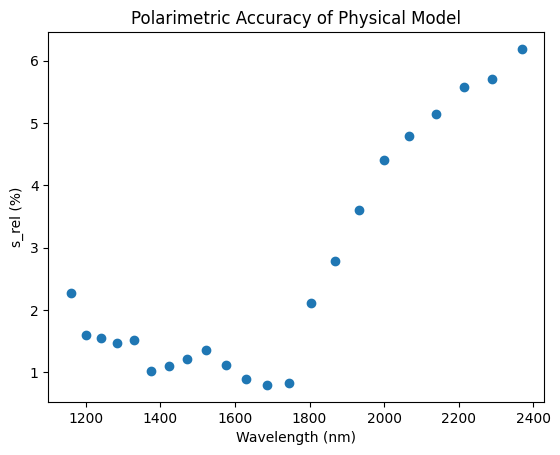

In [42]:
plt.scatter(wavelength_bins, s_res_by_wavelength)
plt.title('Polarimetric Accuracy of Physical Model')
plt.xlabel('Wavelength (nm)')
plt.ylabel ('s_rel (%)')

In [13]:
interleaved_values_unpol,interleaved_stds_unpol, config_list_unpol = read_csv_physical_model_all_bins('../datacsvs/onsky_csvs/unpol_standards',m3=True)
dds_unpol = np.array(process_dataset(interleaved_values_unpol)[::2])

In [14]:
bin_list_unpol = np.array([i for i in wavelength_bins for _ in range(212)])

In [15]:
# calculate s abs

modeled_unpol = np.array([])
for dd in range(len(config_list_unpol)):

    # get model ready
    #hwp_phi = hwp_phi_list[dd]
    #imr_phi = imr_phi_list[dd]
    offset_imr = -0.13959
    offset_hwp = -1.59338
    offset_cal = -0.11835
    #lp_eps = lp_epsilon_list[dd]
    wavelength_bin = bin_list_unpol[dd]
    hwp_phi = HWP_retardance(wavelength_bin, 1.63398,1.27711)[0]
    imr_phi = IMR_retardance(wavelength_bin ,259.11814)[0]
    m1, b1, m2, b2 = (2.19663,13.12958,1.74416,14.05076)

    # define system dictionary
    system_dict_unpol = {
            "components" : {
                "wollaston" : {
                "type" : "wollaston_prism_function",
                "properties" : {"beam": 'o'}, 
                "tag": "internal",
                },
                "image_rotator" : {
                    "type" : "general_retarder_function",
                    "properties" : {"phi": imr_phi, "theta": 0, "delta_theta": offset_imr},
                    "tag": "internal",
                },
                "hwp" : {
                    "type" : "general_retarder_function",
                    "properties" : {"phi": hwp_phi, "theta": 0, "delta_theta": offset_hwp},
                    "tag": "internal",
                },
                "altitude_rot" : {
                    "type" : "rotator_function",
                    "properties" : {"pa":77},
                    "tag":"internal",
                },
                "M3" : {
                    "type" : "SUBARU_M3_function",
                    "properties" : {"wavelength": wavelength_bin, "m1":m1, "b1":b1, "m2":m2, "b2":b2},
                    "tag": "internal",
                },
                "parang_rot" : {
                    "type" : "rotator_function",
                    "properties" : {"pa":39},
                    "tag":"internal",
                },
            }}
                
        
    
    # define p0 dict (it doesnt do anything its just necessary for model function to work)
    p0_dict = {
                "M3" : 
                    {"m1":m1}
            }

    # generate system mueller matrix    
    system_mm = generate_system_mueller_matrix(system_dict_unpol)
    p, pkeys = parse_configuration(p0_dict)
    
    # generate model
    configlist = [config_list_unpol[dd]]
    modeled_dd = model(p, pkeys, system_mm, configlist)
    modeled_unpol = np.concatenate((modeled_unpol, modeled_dd))

modeled_unpol = process_model(modeled_unpol)[::2]

print(modeled_unpol)

Parameter 'wavelength' not found in component 'hwp'. Skipping...
Parameter 'wavelength' not found in component 'image_rotator'. Skipping...
Parameter 'wavelength' not found in component 'hwp'. Skipping...
Parameter 'wavelength' not found in component 'image_rotator'. Skipping...
Parameter 'wavelength' not found in component 'hwp'. Skipping...
Parameter 'wavelength' not found in component 'image_rotator'. Skipping...
Parameter 'wavelength' not found in component 'hwp'. Skipping...
Parameter 'wavelength' not found in component 'image_rotator'. Skipping...
Parameter 'wavelength' not found in component 'hwp'. Skipping...
Parameter 'wavelength' not found in component 'image_rotator'. Skipping...
Parameter 'wavelength' not found in component 'hwp'. Skipping...
Parameter 'wavelength' not found in component 'image_rotator'. Skipping...
Parameter 'wavelength' not found in component 'hwp'. Skipping...
Parameter 'wavelength' not found in component 'image_rotator'. Skipping...
Parameter 'wavelengt

In [16]:
# calculate s res

# generate s
s_res_by_wavelength_unpol = []
for bin in range(22):
    # mask per bin
    bin_mask = []
    for dict in config_list_unpol[::2]:
        if dict['hwp']['wavelength'] == wavelength_bins[bin]:
            bin_mask.append(True)
        else:
            bin_mask.append(False)

    # apply mask
    double_diffs_bin = dds_unpol[bin_mask]
    modeled_double_differences_bin = modeled_unpol[bin_mask]
    # calculate s_res as in appendix E of SPHERE cal paper
    residuals = (double_diffs_bin*100-modeled_double_differences_bin*100)
    s_res = np.sqrt(np.sum(residuals**2)/(len(dds_unpol[bin_mask])))
    s_res_by_wavelength_unpol.append(s_res)

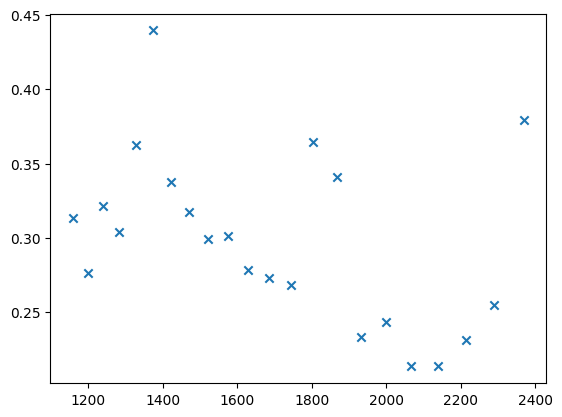

In [17]:
plt.scatter(wavelength_bins, s_res_by_wavelength_unpol, marker='x')